In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -q segmentation_models_pytorch

In [3]:
import os
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
from glob import glob
import gc
import time
from collections import defaultdict
import  matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import copy
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torch.cuda import amp
import torch.optim as optim
import albumentations as A
import segmentation_models_pytorch as smp

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# File preparation
1. get all training / validation images/masks directory
2. don't spend too much time on validation 

In [4]:
from sklearn.model_selection import train_test_split

In [5]:

base_path = '/kaggle/input/blood-vessel-segmentation/train'  
train_base_path = '/kaggle/input/patched-sennet-kidney-1-data'

# train_dataset = ['kidney_1_dense'] #,'kidney_2']
val_img = 'kidney_3_sparse'
val_mask = 'kidney_3_sparse'

image_train_files = []
label_train_files = []


# for dataset in train_dataset:

# images_path = os.path.join(train_base_path, dataset, 'images')
# labels_path = os.path.join(train_base_path, dataset, 'labels')
# images_path = '/kaggle/input/800x800kidney2/train_k1_patch800_img'
# labels_path = '/kaggle/input/800x800kidney2/train_k1_patch800_msk'
images_path = '/kaggle/input/patched-kidney-1/train_k1_patch800_img'
labels_path = '/kaggle/input/patched-kidney-1/train_k1_patch800_msk'
image_files = sorted([os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.tif')])
label_files = sorted([os.path.join(labels_path, f) for f in os.listdir(labels_path) if f.endswith('.tif')])
image_train_files.extend(image_files)
label_train_files.extend(label_files)
image_train_files = image_train_files[3000:]
label_files = label_files[3000:]
print(f'len of image path {len(image_train_files)}')
X_train, X_val, y_train, y_val = train_test_split(image_train_files, label_files, test_size=0.3)

images_val_path = os.path.join(base_path, val_img, 'images')
labels_val_path = os.path.join(base_path, val_mask, 'labels')
image_val_files = sorted([os.path.join(images_val_path, f) for f in os.listdir(images_val_path) if f.endswith('.tif')])
label_val_files = sorted([os.path.join(labels_val_path, f) for f in os.listdir(labels_val_path) if f.endswith('.tif')])
# image_val_files = image_val_files[1000:1500]
# label_val_files = label_val_files[1000:1500]
print(f"len of val path {len(image_val_files)}")
print(len(label_val_files))

len of image path 10350
len of val path 1035
1035


In [6]:
class CFG:
    backbone = "resnext50_32x4d"
    train_bs = 1
    valid_bs = 1
    img_size = [800,800]
    epochs = 10
    lr = 1e-3
    over_lap = 0.3
    patch_size = 800
    bin_path = '/kaggle/input/resnext-k1-800/resnext_k1_800.bin'

    num_classes   = 1
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    data_transforms = {
        "train": A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
        ], p=1.0),
        
        "valid": A.Compose([
        ], p=1.0)
    }
    

# Dataloader:
this dataloader return the original size for testing 

In [7]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

def load_msk(path):
    msk = cv2.imread(path, cv2.IMREAD_UNCHANGED) 
    msk = msk.astype('float32')
    msk/=255.0
    return msk

In [8]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, msk_paths=[], transforms=None):
        self.img_paths  = img_paths
        self.msk_paths  = msk_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        img = load_img(img_path)
        
        if len(self.msk_paths)>0:
            msk_path = self.msk_paths[index]
            msk = load_msk(msk_path)
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img), torch.tensor(msk)
        else:
            orig_size = img.shape
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img), torch.tensor(np.array([orig_size[0], orig_size[1]]))

In [9]:
#X_train, X_val, y_train, y_val
# image_val_files = sorted([os.path.join(images_val_path, f) for f in os.listdir(images_val_path) if f.endswith('.tif')])
# label_val_files
train_dataset = BuildDataset(X_train, y_train, transforms=CFG.data_transforms['train'])
valid_dataset = BuildDataset(X_val, y_val, transforms=None)
psudo_test_dataset = BuildDataset(image_val_files,label_val_files,transforms=None)
train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, num_workers=0, shuffle=True, pin_memory=True, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, num_workers=0, shuffle=False, pin_memory=True)
psudo_test_loader = DataLoader(psudo_test_dataset, batch_size=1, num_workers=0, shuffle=False, pin_memory=True)

resnet: https://arxiv.org/abs/1611.05431

In [10]:
class attention_block(nn.Module):
    def __init__(self, F_g, F_l, n_coefficients):
        super(attention_block, self).__init__()

        self.bypass = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.upsample = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection):
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        g1 = self.upsample(gate)
        x1 = self.bypass(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out

class MyUNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=1),
                    torch.nn.ReLU(),
                )
        return block
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
            )
            return  block

    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=1):
            block = torch.nn.Sequential(
                    
                    torch.nn.Conv2d(kernel_size=3, in_channels=in_channels, out_channels=mid_channel, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=0),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
            )
            return  block

    def __init__(self, in_channel, out_channel):
        super(MyUNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512, padding=1),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512, padding=1),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )

        # Decode
        self.attention3 = attention_block(256, 256, 128)
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.attention2 = attention_block(128, 128, 64)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.attention1 = attention_block(64, 64, 32)
        self.final_layer = self.final_block(128, 64, out_channel)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottle_neck1 = self.bottleneck(encode_pool3)
        # Decode
        att_3 = self.attention3(bottle_neck1, encode_block3) 
        decode_block1 = torch.cat((bottle_neck1, att_3), 1)
        cat_layer2 = self.conv_decode3(decode_block1)
        
        att_2 = self.attention2(cat_layer2, encode_block2) 
        decode_block2 = torch.cat((cat_layer2, att_2), 1)
        cat_layer1 = self.conv_decode2(decode_block2)
        
        
        att_1 = self.attention1(cat_layer1, encode_block1) 
        decode_block3 = torch.cat((cat_layer1, att_1), 1)
        final_layer = self.final_layer(decode_block3)
        return final_layer
def build_model(backbone, num_classes, device):
    model = MyUNet(in_channel=3, out_channel=num_classes)
    model.to(device)
    return model

def load_model(backbone, num_classes, device, path):
    model = build_model(backbone, num_classes, device)
    model.load_state_dict(torch.load(path))
    return model

model = build_model(CFG.backbone, 
                   1, 
                   CFG.device, )
# model = build_model(
#     CFG.backbone,
#     num_classes = 1,
#     device = CFG.device
#     )

In [11]:
def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.unsqueeze(1).to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.unsqueeze(1).to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

In [12]:
criterion = smp.losses.DiceLoss(mode='binary')


In [13]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
    
        y_pred = model(images)
        loss   = criterion(y_pred, masks)
        loss.backward()
        optimizer.step()

        # zero the parameter gradients
        optimizer.zero_grad()

        if scheduler is not None:
            scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix( epoch=f'{epoch}',
                          train_loss=f'{epoch_loss:0.4f}',
                          lr=f'{current_lr:0.5f}',
                          gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    return epoch_loss

In [14]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    return epoch_loss, val_scores

# pseudo test on performance

In [15]:

def patch_image(img, patch_size, model = None, over_lap=0.2):
    """
    Splits the image into patches with overlap.

    """
    shape = img.shape

    height, width = shape[2],shape[3]

    stride = patch_size * (1 - over_lap)
    num_patches = np.ceil(np.array([height, width]) / stride).astype(np.int64)
    starts = [np.int64(np.linspace(0, width - patch_size, num_patches[1])),
              np.int64(np.linspace(0, height - patch_size, num_patches[0]))]
    patches = []
    for y in starts[1]:
        for x in starts[0]:
            if model != None: 
                patch_img = img[:,:,y:y + patch_size, x:x + patch_size]
#                 print(type(patch_img)," and shape is ",patch_img.shape)
#                 print(f'inside the patch function: size of patched image: {np.shape(patch_img)}')
                patches.append(patch_img)
    patches = torch.cat(patches,dim = 0)
    pred = model(patches)
    return pred


def combine_patches_torch(patches, original_shape, patch_size, over_lap=0.1):
    height, width = original_shape[2],original_shape[3]
    stride = int(patch_size * (1 - over_lap))
    combined = np.zeros((height, width), dtype=np.float32)
    weight = np.zeros((height, width), dtype=np.float32)

    num_patches_y = np.ceil(height / stride).astype(np.int64)
    num_patches_x = np.ceil(width / stride).astype(np.int64)

    starts_y = np.linspace(0, height - patch_size, num_patches_y).astype(np.int64)
    starts_x = np.linspace(0, width - patch_size, num_patches_x).astype(np.int64)

    patch_idx = 0
    for y in starts_y:
        for x in starts_x:
            
            patch = patches[patch_idx].detach().cpu()
            patch = patch.numpy().astype(np.float32)
#             print(f'inside the combine function: type of combine = {type(combined)}, shape of patches = {np.shape(patch)}')
            # with torch, I cannot add different sized tensor together 
            combined[y:y + patch_size, x:x + patch_size] += patch.squeeze()
            weight[y:y + patch_size, x:x + patch_size] += 1.0
            patch_idx += 1

    # Avoid division by zero
    weight[weight == 0] = 1.0
    combined = combined / weight
    combined = torch.from_numpy(combined)
    combined = combined.unsqueeze(0).unsqueeze(0)
    
    return combined



# Sanity check

torch.Size([3, 800, 800])
torch.Size([800, 800])


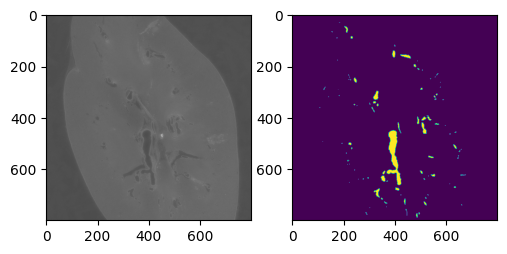

torch.Size([3, 800, 800])
torch.Size([800, 800])


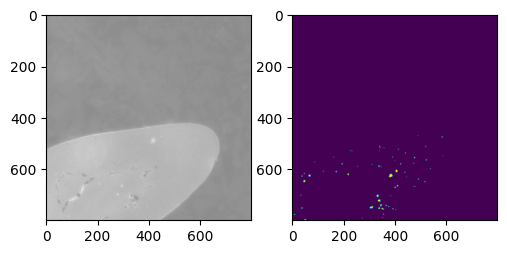

torch.Size([3, 800, 800])
torch.Size([800, 800])


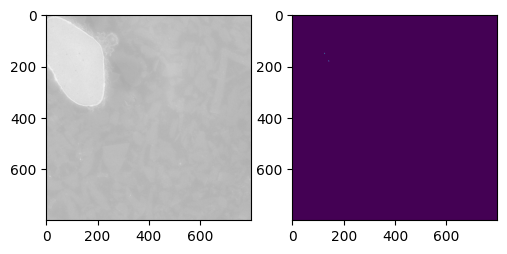

torch.Size([3, 800, 800])
torch.Size([800, 800])


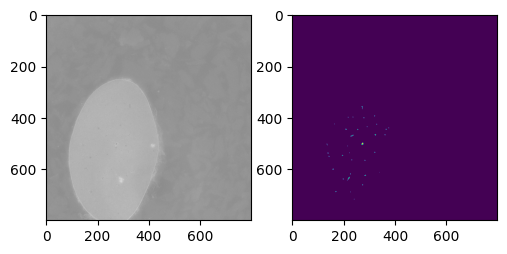

torch.Size([3, 800, 800])
torch.Size([800, 800])


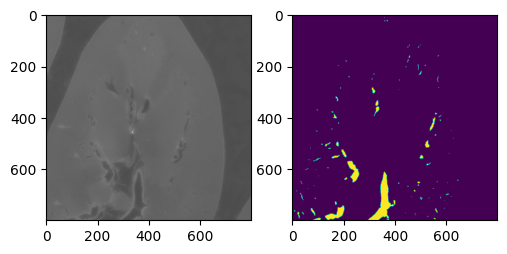

torch.Size([3, 800, 800])
torch.Size([800, 800])


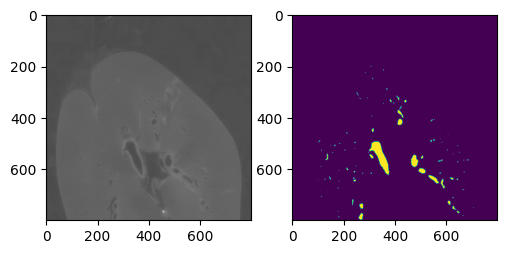

torch.Size([3, 800, 800])
torch.Size([800, 800])


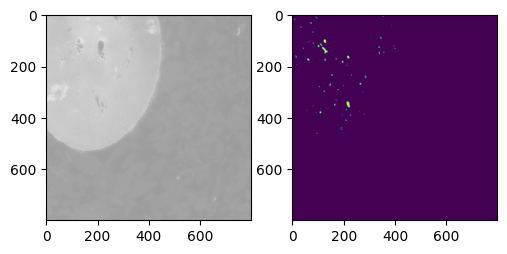

torch.Size([3, 800, 800])
torch.Size([800, 800])


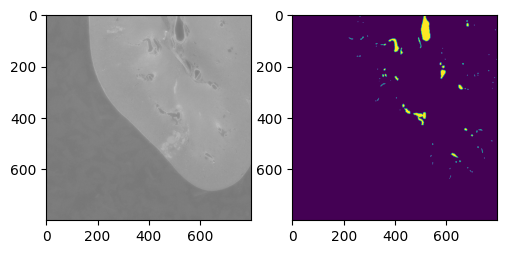

torch.Size([3, 800, 800])
torch.Size([800, 800])


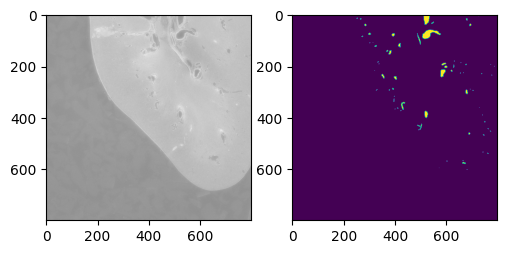

torch.Size([3, 800, 800])
torch.Size([800, 800])


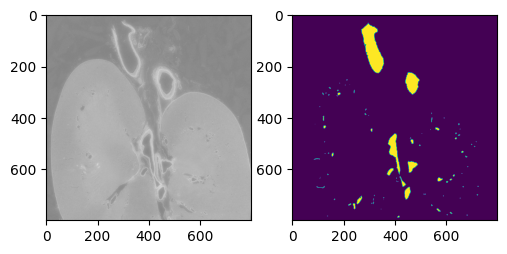

torch.Size([3, 800, 800])
torch.Size([800, 800])


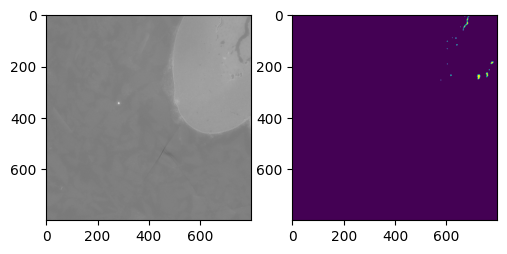

torch.Size([3, 800, 800])
torch.Size([800, 800])


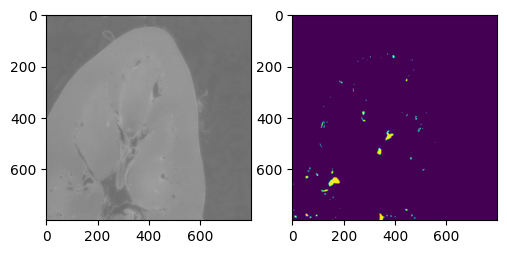

torch.Size([3, 800, 800])
torch.Size([800, 800])


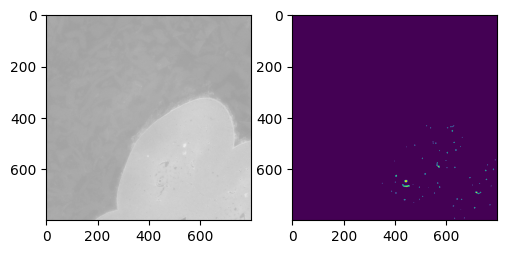

torch.Size([3, 800, 800])
torch.Size([800, 800])


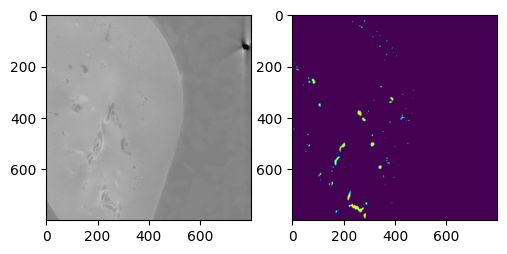

torch.Size([3, 800, 800])
torch.Size([800, 800])


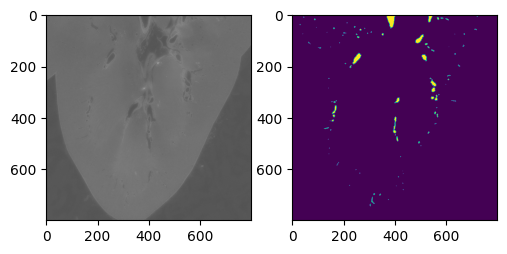

torch.Size([3, 800, 800])
torch.Size([800, 800])


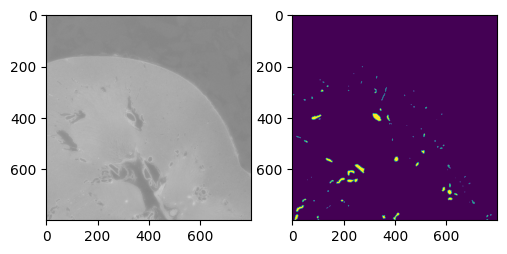

torch.Size([3, 800, 800])
torch.Size([800, 800])


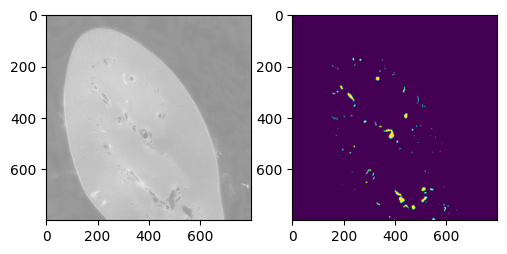

torch.Size([3, 800, 800])
torch.Size([800, 800])


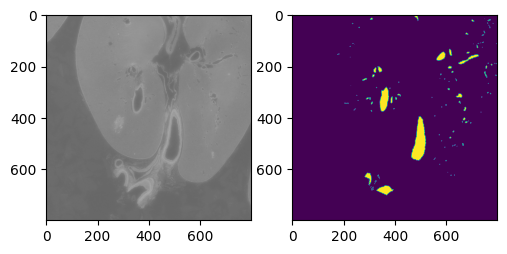

torch.Size([3, 800, 800])
torch.Size([800, 800])


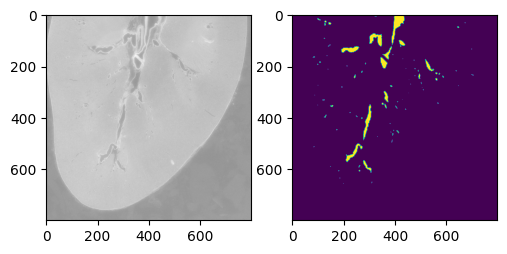

torch.Size([3, 800, 800])
torch.Size([800, 800])


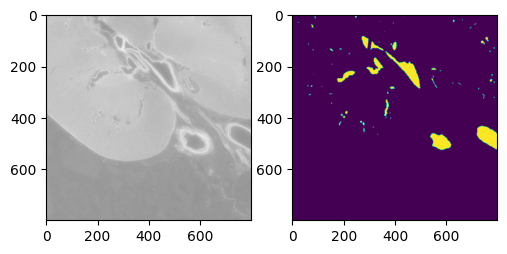

In [16]:
sample_ids = [random.randint(0, len(train_dataset)) for _ in range(20)]
for id in sample_ids:
    img, msk =  train_dataset[id]
    print(img.shape)
    print(msk.shape)
    img = img.permute((1, 2, 0)).numpy()*255.0
    img = img.astype('uint8')
    msk = (msk).numpy().astype('uint8')
#     print(img.shape)
#     print(msk.shape)
    plt.figure(figsize=(9, 4))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.imshow(msk)
    plt.show()
#     msks = patch_image(msk,512)
#     for i in msks: 
#         print(i.shape)
#     ori_shape =msk.shape
#     c_m = combine_patches(msks,original_shape = ori_shape,patch_size = 512)
#     plt.subplot(1,3,3)
#     plt.imshow(c_m)
#     plt.show()
    
    

In [17]:
@torch.no_grad()
def test_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        ori_shape = images.shape
        patches = patch_image(images,patch_size=CFG.patch_size,over_lap = CFG.over_lap,model = model)
        y_pred  = combine_patches_torch(patches,ori_shape,patch_size=CFG.patch_size,over_lap = CFG.over_lap)
        y_pred=y_pred.to(device, dtype=torch.float)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
      
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
        
    return epoch_loss, val_scores

In [18]:
from colorama import Fore, Back, Style #?
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

In [19]:
def run_training(model, optimizer, scheduler, device, num_epochs):    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss      = np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
#         test_loss, test_scores = test_one_epoch(model,
#                psudo_test_loader,
#                device=CFG.device,
#                epoch=epoch)
        val_dice, val_jaccard = val_scores
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)        
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        print(f'Valid Loss: {val_loss}')
#         print(f'pseudo test loss: {test_loss}')
        
        # deep copy the model
        if val_loss <= best_loss:
            print(f"{c_}Valid loss Improved ({best_loss} ---> {val_loss})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_loss = val_loss
            best_epoch   = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "best_epoch.bin"
            torch.save(model.state_dict(), PATH)
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = "last_epoch.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [20]:
optimizer = optim.Adam(model.parameters(), lr=CFG.lr)
scheduler = None
model, history = run_training(model, optimizer, scheduler,
                                device=CFG.device,
                                num_epochs=CFG.epochs)

cuda: Tesla P100-PCIE-16GB

Epoch 1/10

Valid : 100%|██████████| 3105/3105 [07:19<00:00,  7.07it/s, gpu_memory=2.47 GB, lr=0.00100, valid_loss=0.5290]


Valid Dice: 0.5138 | Valid Jaccard: 0.4163
Valid Loss: 0.5290352726712128
Valid loss Improved (inf ---> 0.5290352726712128)
Model Saved


Epoch 2/10

Valid : 100%|██████████| 3105/3105 [06:17<00:00,  8.22it/s, gpu_memory=2.48 GB, lr=0.00100, valid_loss=0.4409]


Valid Dice: 0.5630 | Valid Jaccard: 0.4514
Valid Loss: 0.4409433430903584
Valid loss Improved (0.5290352726712128 ---> 0.4409433430903584)
Model Saved


Epoch 3/10

Valid : 100%|██████████| 3105/3105 [06:19<00:00,  8.18it/s, gpu_memory=2.48 GB, lr=0.00100, valid_loss=0.5083]


Valid Dice: 0.4931 | Valid Jaccard: 0.3959
Valid Loss: 0.5082591984391021


Epoch 4/10

Valid : 100%|██████████| 3105/3105 [06:22<00:00,  8.12it/s, gpu_memory=2.47 GB, lr=0.00100, valid_loss=0.4422]


Valid Dice: 0.5581 | Valid Jaccard: 0.4613
Valid Loss: 0.44218569997812046


Epoch 5/10

Valid : 100%|██████████| 3105/3105 [06:20<00:00,  8.17it/s, gpu_memory=2.47 GB, lr=0.00100, valid_loss=0.4169]


Valid Dice: 0.5832 | Valid Jaccard: 0.4957
Valid Loss: 0.41687144471059484
Valid loss Improved (0.4409433430903584 ---> 0.41687144471059484)
Model Saved


Epoch 6/10

Valid : 100%|██████████| 3105/3105 [06:17<00:00,  8.21it/s, gpu_memory=2.47 GB, lr=0.00100, valid_loss=0.3608]


Valid Dice: 0.6393 | Valid Jaccard: 0.5495
Valid Loss: 0.36077763531327056
Valid loss Improved (0.41687144471059484 ---> 0.36077763531327056)
Model Saved


Epoch 7/10

Valid : 100%|██████████| 3105/3105 [06:39<00:00,  7.78it/s, gpu_memory=2.52 GB, lr=0.00100, valid_loss=0.3938]


Valid Dice: 0.6062 | Valid Jaccard: 0.5079
Valid Loss: 0.3937532864139084


Epoch 8/10

Valid : 100%|██████████| 3105/3105 [06:31<00:00,  7.93it/s, gpu_memory=2.48 GB, lr=0.00100, valid_loss=0.5636]


Valid Dice: 0.4364 | Valid Jaccard: 0.3642
Valid Loss: 0.5636193283706088


Epoch 9/10

Valid : 100%|██████████| 3105/3105 [06:32<00:00,  7.90it/s, gpu_memory=2.48 GB, lr=0.00100, valid_loss=0.3466]


Valid Dice: 0.6534 | Valid Jaccard: 0.5734
Valid Loss: 0.346603748821406
Valid loss Improved (0.36077763531327056 ---> 0.346603748821406)
Model Saved


Epoch 10/10

Valid : 100%|██████████| 3105/3105 [06:32<00:00,  7.92it/s, gpu_memory=2.50 GB, lr=0.00100, valid_loss=0.3226]


Valid Dice: 0.6774 | Valid Jaccard: 0.5988
Valid Loss: 0.322649694679248
Valid loss Improved (0.346603748821406 ---> 0.322649694679248)
Model Saved


Training complete in 7h 4m 4s
Best Loss: 0.3226


In [21]:
test_loss, test_scores = test_one_epoch(model,
               psudo_test_loader,
               device=CFG.device,
               epoch=1)
print(test_loss)

Valid :   0%|          | 0/1035 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.83 GiB (GPU 0; 15.90 GiB total capacity; 13.42 GiB already allocated; 967.75 MiB free; 14.03 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF